# Task 1
## Process Model Derivation
Considering the drone as a point mass $m$, the governing equation for the system is $u = m\ddot{p}$

Modeling the system as a continuous state-space model with states $x = \begin{bmatrix} p \\ \dot{p} \end{bmatrix}$ yields

\begin{equation}
\dot{x} = \begin{bmatrix} 0 & 1 \\ 0 & 0 \end{bmatrix}x + \begin{bmatrix} 0 \\ \frac{1}{m} \end{bmatrix}u \\
\dot{x} = Ax + Bu
\tag{1}
\end{equation}

Here $A = \begin{bmatrix} 0 & 1 \\ 0 & 0 \end{bmatrix}$ and $B = \begin{bmatrix} 0 \\ \frac{1}{m} \end{bmatrix}$

$\dot{x}$ can be written as

\begin{equation}
\dot{x} = \frac{x_{k+1} - x_{k}}{dt}
\tag{2}
\end{equation}

where $x_{k+1}$, $x_{k}$ are the next and current discrete states, and $dt$ is the time step.

Equating (1) and (2):

\begin{equation}
\frac{x_{k+1} - x_{k}}{dt} = Ax_{k} + Bu_{k} \\
x_{k+1} = x_{k} + Ax_{k}dt + Bu_{k}dt \\
x_{k+1} = (I + Adt)x_{k} + (Bdt)u_{k} \\
\end{equation}
\begin{equation}
x_{k+1} = A_{d}x_{k} + B_{d}u_{k}
\tag{3}
\end{equation}

Here $A_{d} = I + Adt$ and $B_{d} = Bdt$

Since $p$ is actually a 3X1 vector, the actual matrices are

\begin{equation}
A_{d} = \begin{bmatrix} I_{3 \times 3} & dt \cdot I_{3 \times 3} \\ 0 & I_{3 \times 3} \end{bmatrix}_{6 \times 6} \\
B_{d} = \begin{bmatrix} O_{3 \times 3} \\ \frac{dt}{m} \cdot I_{3 \times 3} \end{bmatrix}_{6 \times 3}
\tag{4}
\end{equation}

## Measurement Model
Measurements $y$ can be written as $y = Cx$ where $C$ is the measurement matrix with size 3X6.

There would be two measurement matrices as we have position and velocity measurements in separate files.

* For Position measurements: $C_{\text{pos}} = \begin{bmatrix} I_{3 \times 3} & O_{3 \times 3} \end{bmatrix}$
* For Velocity measurements: $C_{\text{vel}} = \begin{bmatrix} O_{3 \times 3} & I_{3 \times 3} \end{bmatrix}$

A flag variable is itroduced in the code to choose between the matrices.


# Task 2
Kalman Filter Implementation

In [64]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

In [65]:
def kalman_filter(x_prev,u_curr,P_prev,y_curr,dt,Q,R,flag):
  """
  Estimates the state of the drone using the kalman filter algorithm

  Inputs:
    - x_prev: previous state (6X1 np.array)
    - u_curr: current input to the system (3X1 np.array)
    - P_prev: covariance matrix of state estimate at previuos time step (6X6 np.array)
    - y_curr: current measurement (3X1 np.array)
    - dt: timestep (seconds)
    - Q: process noise (6X6 np.array)
    - R: measurement noise (3X3 np.array)
    - flag: To choose measurement matrix (True or False)
            * True  - Position measurement
            * False - Velocity measurement

  Outputs:
    - x: current state estimate (6X1 np.array)
    - P: updated covariance matrix of state estimate (6X6 np.array)

  """
  # init mass
  m = 0.027 # kg

  # init process matrices
  A = np.array([[1,0,0,dt,0,0],
                [0,1,0,0,dt,0],
                [0,0,1,0,0,dt],
                [0,0,0,1,0,0],
                [0,0,0,0,1,0],
                [0,0,0,0,0,1]])

  B = np.vstack((np.zeros((3,3))*dt**2/(2*m),np.eye(3)*dt/m))

  # init measurement matrix
  if flag:
    # position measurements
    C = np.hstack((np.eye(3),np.zeros((3,3))))
  else:
    # velocity measurements
    C = np.hstack((np.zeros((3,3)),np.eye(3)))

  # prediction
  # predict state
  x_pred = A @ x_prev + B @ u_curr
  # preditc uncertainity
  P_pred = A @ P_prev @ A.T + Q

  # update
  # compute kalman gain
  K = P_pred @ C.T @ np.linalg.inv(C @ P_pred @ C.T + R)
  # update estimate
  x= x_pred + K @ (y_curr - C @ x_pred)
  # update uncertainity
  P = (np.eye(6) - K @ C) @ P_pred

  return x,P

In [142]:
def kalman_loop(data,P_init,Q,R,flag):
  """
  Runs kalman filter on the array of data by looping over it
  Input:
    - data: NX6 np.array
    - P_init: initial state covariance matrix
    - Q: process noise (6X6 np.array)
    - R: measurement noise (3X3 np.array)
    - flag: To choose measurement matrix (True or False)
            * True  - Position measurement
            * False - Velocity measurement
  output:
    - x: estimated state vector NX6
  """
  # var to store state
  x = np.zeros((data.shape[0],6))

  # initial time
  t_prev = data[0,0]

  # initial state estimate
  if flag:    # intial position
    x[0,0:3] = data[0,4:]
  else:       # intial velocity
    x[0,3:] = data[0,4:]

  # initial covariance/uncertainity
  P_prev = P_init

  # loop over data
  for i in range(1,data.shape[0]):

    # retreive control input, measurement and time for current step
    u_curr = data[i,1:4].reshape(3,1)
    y_curr = data[i,4:].reshape(3,1)
    t_curr = data[i,0]

    # calculate timestep
    dt = t_curr - t_prev

    # estimate state from kalman filter
    [x_hat,P] = kalman_filter(x[i-1,:].reshape(6,1),u_curr,P_prev,y_curr,dt,Q,R,flag)

    # store current values
    x[i,:] = x_hat.reshape(1,-1)[0]
    P_prev = P
    t_prev = t_curr

  return x


In [138]:
def plot_3Dpos(x,gt):
  """
  Creates a 3D plot of position given state array x
  Input:
    - x : 3XN state vector where N is the number of instances
    - gt: 3XN ground truth position vector
  Output:
    - 3D line plot of the position from state vector x (red) and groundtruth position (blue)
  """
  # Create a 3D plot
  fig = plt.figure()
  ax = fig.add_subplot(111, projection='3d')

  # Scatter plot
  ax.plot(gt[:,0], gt[:,1], gt[:,2],'b',label='Ground Truth',alpha=0.80)
  ax.plot(x[:,0], x[:,1], x[:,2],'r',label='Estimated Position')


  # Set axis labels
  ax.set_xlabel('X')
  ax.set_ylabel('Y')
  ax.set_zlabel('Z')
  plt.legend()

  # Show the plot
  plt.show()


## Low Noise Data
Given, Measurement noise $R = (0.05^2)I_{3X3}$. I initialized the initial covariance as $P = I_{6X6}$, which means that the standard deviation is $σ = 1m$ (which I think is reasonable)

I started by initializing process noise as $Q = (σ^2)I_{6X6}$ with $σ = 1$. The intial estimates were very bad. As I decreased the σ value the estimates starting getting better and at $σ = 0.0005$ I get good estimates that are close to the motion capture ground truth.

However I observed that further decreasing the $σ < 0.0001$ resulted in the estimates getting worse. In addition, I observed that decreasing the initial state covariance P resulted in better estimates.

Final values:
* $P = (0.01^2)I_{6X6}$
* $Q = (0.0005^2)I_{6X6}$
* $R = (0.05^2)I_{3X3}$

In [146]:
# import motion capture data from txt file into np array
data_mocap = np.genfromtxt('kalman_filter_data_mocap.txt', delimiter=',', dtype=None, encoding=None)
data_mocap_pos = data_mocap[:,4:]

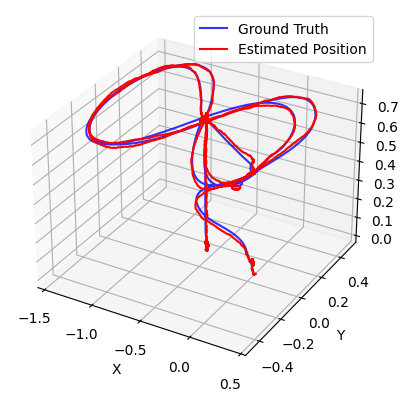

In [147]:
# import data from txt file into np array
data_low_noise = np.genfromtxt('kalman_filter_data_low_noise.txt', delimiter=',', dtype=None, encoding=None)

# initial covariance/uncertainity
P_init = (0.01**2)*np.eye(6)
# init process noise
Q = (0.0005**2)*np.eye(6)
# init measurement noise
R = (0.05**2)*np.eye(3)

# estimate states
x_low_noise = kalman_loop(data_low_noise,P_init,Q,R,True)

# plot the estimated postion data
plot_3Dpos(x_low_noise[:,0:3],data_mocap_pos)

## High Noise data
Final values:
* $P = (0.01^2)I_{6X6}$
* $Q = (0.001^2)I_{6X6}$
* $R = (0.20^2)I_{3X3}$

The results do not look good. However decreasing Q further causes the estimates to drift further away from the ground truth.

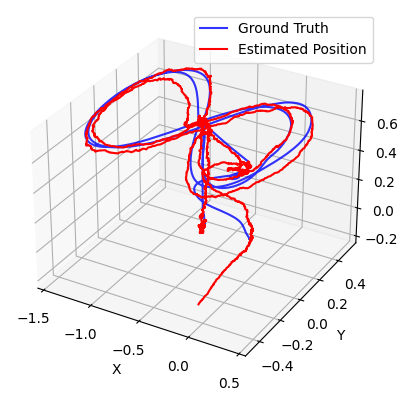

In [148]:
# import data from txt file into np array
data_high_noise = np.genfromtxt('kalman_filter_data_high_noise.txt', delimiter=',', dtype=None, encoding=None)
data_mocap = np.genfromtxt('kalman_filter_data_mocap.txt', delimiter=',', dtype=None, encoding=None)

# initial covariance/uncertainity
P_init = (0.01**2)*np.eye(6)

# init process noise
Q = (0.001**2)*np.eye(6)
# init measurement noise
R = (0.20**2)*np.eye(3)


# estimate states
x_high_noise = kalman_loop(data_high_noise,P_init,Q,R,True)

# plot the estimated postion data
plot_3Dpos(x_high_noise,data_mocap_pos)

## Velocity Data
Final values:
* $P = (0.01^2)I_{6X6}$
* $Q = (0.001^2)I_{6X6}$
* $R = (0.20^2)I_{3X3}$

There is an offset observed between the estimated states and the ground truth. This is because the intial position estimate is (0,0,0) and the actual postion is different. Also we only have the velocity measurements so we cannot correct for the position initially.

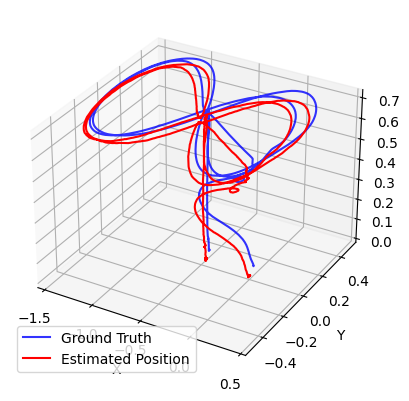

In [149]:
# import data from txt file into np array
data_velocity = np.genfromtxt('kalman_filter_data_velocity.txt', delimiter=',', dtype=None, encoding=None)
data_mocap = np.genfromtxt('kalman_filter_data_mocap.txt', delimiter=',', dtype=None, encoding=None)

# initial covariance/uncertainity
P_init = (0.01**2)*np.eye(6)

# init process noise
Q = (0.001**2)*np.eye(6)
# init measurement noise
R = (0.05**2)*np.eye(3)

# estimate states
x_vel = kalman_loop(data_velocity,P_init,Q,R,False)

# plot the estimated postion data
plot_3Dpos(x_vel,data_mocap_pos)

# Motion Capture Data
No matter what values of P,Q,R are used the estimated position and the groud truth are almost the same.

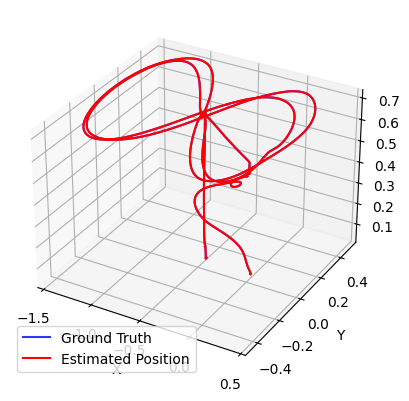

In [165]:
# import data from txt file into np array
data_mocap = np.genfromtxt('kalman_filter_data_mocap.txt', delimiter=',', dtype=None, encoding=None)

# initial covariance/uncertainity
P_init = (1)*np.eye(6)

# init process noise
Q = (1)*np.eye(6)
# init measurement noise
R = (1)*np.eye(3)

# estimate states
x_vel = kalman_loop(data_mocap,P_init,Q,R,True)

# plot the estimated postion data
plot_3Dpos(x_vel,data_mocap_pos)